In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science: 
## Homework 4: Classification: Predicting College Admissions

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2.4pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

<div style = "background: lightgreen; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with slighlty longer output. Avoid excessively long output.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

### Import Libraries

In [3]:
# RUN THIS CELL
import itertools
import math
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [4]:
# For calculating total notebook runtime
notebook_start = time.time()

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data exploration using train and basic models**](#part1)

- [**Question 2: Interpretable modeling**](#part2)

- [**Question 3: Harvard and Yale?**](#part3)

- [**Question 4: Building predictive models for admitted**](#part4)

- [**Question 5: Evaluating results**](#part5)

- [**Question 6: BONUS!**](#part6)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting admissions into elite universities

In this problem set we will model the chances of high school students being accepted into two different elite undergraduate colleges: Harvard and Yale.

The data are provided in the file `data/college_admissions.csv` and were scraped in 2022 from [collegedata.com](https://www.collegedata.com/) (where applicants volunteer to share their information).  Each observation corresponds to an applicant to one of the two different colleges (note: the same applicant may show up in two rows: once for each college).  The main response is the `"admitted"` variable (1 = admitted, 0 = denied), and there are are several predictors to consider:

- **id**: a unique identifier for the applicant 
- **test_score**: a standardized measurement of the applicant's highest ACT or SAT combined score (2400 is the maximum)
- **ap**: the number of AP tests taken
- **avg_ap**: the average score on the AP tests taken (0 if no tests were taken)
- **sat_subjects**: the number of SAT subject tests taken
- **gpa**: the unweighted GPA of the applicant (max of 4.0)
- **female**:  a binary indicator for gender: 1 = female, 0 = otherwise
- **minority**: a binary indicator for under-represented minority: 1 = minority, 0 = otherwise 
- **international**: a binary indicator for international status: 1 = international, 0 = United States
- **sports**: a binary indicator for High School All-American: 1 = all-American athlete, 0 = otherwise
- **harvard**: a categorical variable for school applied to: 1 = Harvard, 0 = Yale
- **early_app**: a binary indicator for application type: 1 = early action, 0 = regular
- **alumni**:  a binary indicator for parents' alumni status of school: 1 = a parent is an alumnus, 0 = otherwise
- **program**: the program applied to by the student with many choices (we will not use this as a predictor)
- **add_info**: additional (optional) info provided by applicant (we will not use this as a predictor)

**The main set of 12 predictors is:**

```python
[
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]
```

Please note, you may need to modify this list when fitting different models.


**IMPORTANT NOTES:**

- Unless stated otherwise, all logistic regression models should be unregularized (use `penalty=None`) and include the intercept (which is the default in `sklearn`).


- When printing your output (e.g. coefficients, accuracy scores, etc.), DO NOT just print numbers without context. Please be certain provide clarifying labels for all printed numbers and limit the number of digits showing after decimals to a reasonable length (e.g. 4 decimal points for coefficients and accuracy scores).


- Also be sure to practice good data science principles: always use train to do analysis and never touch the test set until the very end.

---

<a id="part1"></a>

## <div class='exercise'>Question 1: Data exploration using train and basic models</div>

[Return to contents](#contents)

The first step is to split the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. 

**IMPORTANT:** While an argument could be made to scale our predictors here, please **DO NOT** do so **UNTIL** it is requested of you in **[Question 4.1](#part4)**.


In [5]:
#############################
## DO NOT MODIFY THIS CODE ##
#############################
np.random.seed(121)

college = pd.read_csv("data/college_admissions.csv")

college_train, college_test = train_test_split(
    college,
    test_size=0.2,
    random_state=121,
    shuffle=True,
    stratify=college["admitted"],
)

print(college.shape)
print(college_train.shape, college_test.shape)
display(college_train.head())
college_train.info()

# Separate predictors from response
X_train, y_train = college_train.drop(columns=["admitted"]), college_train["admitted"]
X_test, y_test = college_test.drop(columns=["admitted"]), college_test["admitted"]

(1871, 16)
(1496, 16) (375, 16)


,id,admitted,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,program,add_info,harvard
192,NYFN0GE0KK,1,2310,7,5.000,5,3.98,0,0,0,0,0,0,Economics,Activities Activity Position Honors Grade Levels Approximate Time When Participated Participate ...,1
652,50FWDZ3MBF,1,2010,3,4.333,3,3.75,1,1,0,0,0,0,History Political Science,Drama Club Co founder of a Community Outreach Organization called Los Amigos volunteered helped ...,1
593,KYYHQRHBV9,0,2080,5,4.200,2,3.85,0,0,0,0,0,0,Biology Pre Med,moderate a few sports and clubs and a part time jobfamily circumstances positive,1
331,JQ8O4AV4VM,0,2250,0,0.000,2,4.00,0,0,0,0,0,0,Physics,NaN,1
1117,SJUQZVBA7K,0,2230,4,4.000,5,3.96,1,0,0,0,1,0,Chemistry Chemical Engineering,MUN Advisor 12 10 National Honors Society 12 10 California Scholarship Federation 12 9 Book Club...,0


<class 'pandas.core.frame.DataFrame'>
Index: 1496 entries, 192 to 1296
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1496 non-null   object 
 1   admitted       1496 non-null   int64  
 2   test_score     1496 non-null   int64  
 3   ap             1496 non-null   int64  
 4   avg_ap         1496 non-null   float64
 5   sat_subjects   1496 non-null   int64  
 6   gpa            1496 non-null   float64
 7   female         1496 non-null   int64  
 8   minority       1496 non-null   int64  
 9   international  1496 non-null   int64  
 10  sports         1496 non-null   int64  
 11  early_app      1496 non-null   int64  
 12  alumni         1496 non-null   int64  
 13  program        1298 non-null   object 
 14  add_info       949 non-null    object 
 15  harvard        1496 non-null   int64  
dtypes: float64(2), int64(11), object(3)
memory usage: 198.7+ KB


<div class='exercise-r'>

**Q1.1** Consider a baseline, "naive" model that predicts that *ALL* applicants belong to the same class. This class prediction is *not* determined by an applicant's feature values, but rather by the proportion of observations in the training data belonging to each class.

Calculate the accuracy of this naive model on the training data and store it in `naive_train_acc`.
    
**NOTE:** For this assignment, use the convention that accuracies range from 0 to 1 (to be consistant with sklearn).
    
</div>

In [6]:
# your code here
# The naive model assumes everybody got rejected; the other way was a lower percentage
naive_train_acc = (y_train[y_train == 0].count()) / len(y_train)

In [7]:
print("Naive Classification Model Based on Training Proportions")
print(f"\tTrain Accuracy: {naive_train_acc:.4f}")

Naive Classification Model Based on Training Proportions
	Train Accuracy: 0.7299


In [8]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.2** Let's investigate how each of our 12 predictors is associated with whether or not an applicant is admitted into the college to which they applied (`admitted`). To this end, create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a grid of subplots with 3 columns and 4 rows.

</div>

In [9]:
# Create dummy variable
# your code here
# Just keeping it here for now
predictors = [
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]

Probability of being admitted if alumni = 0 is 0.2604
Probability of being admitted if alumni = 1 is 0.4516


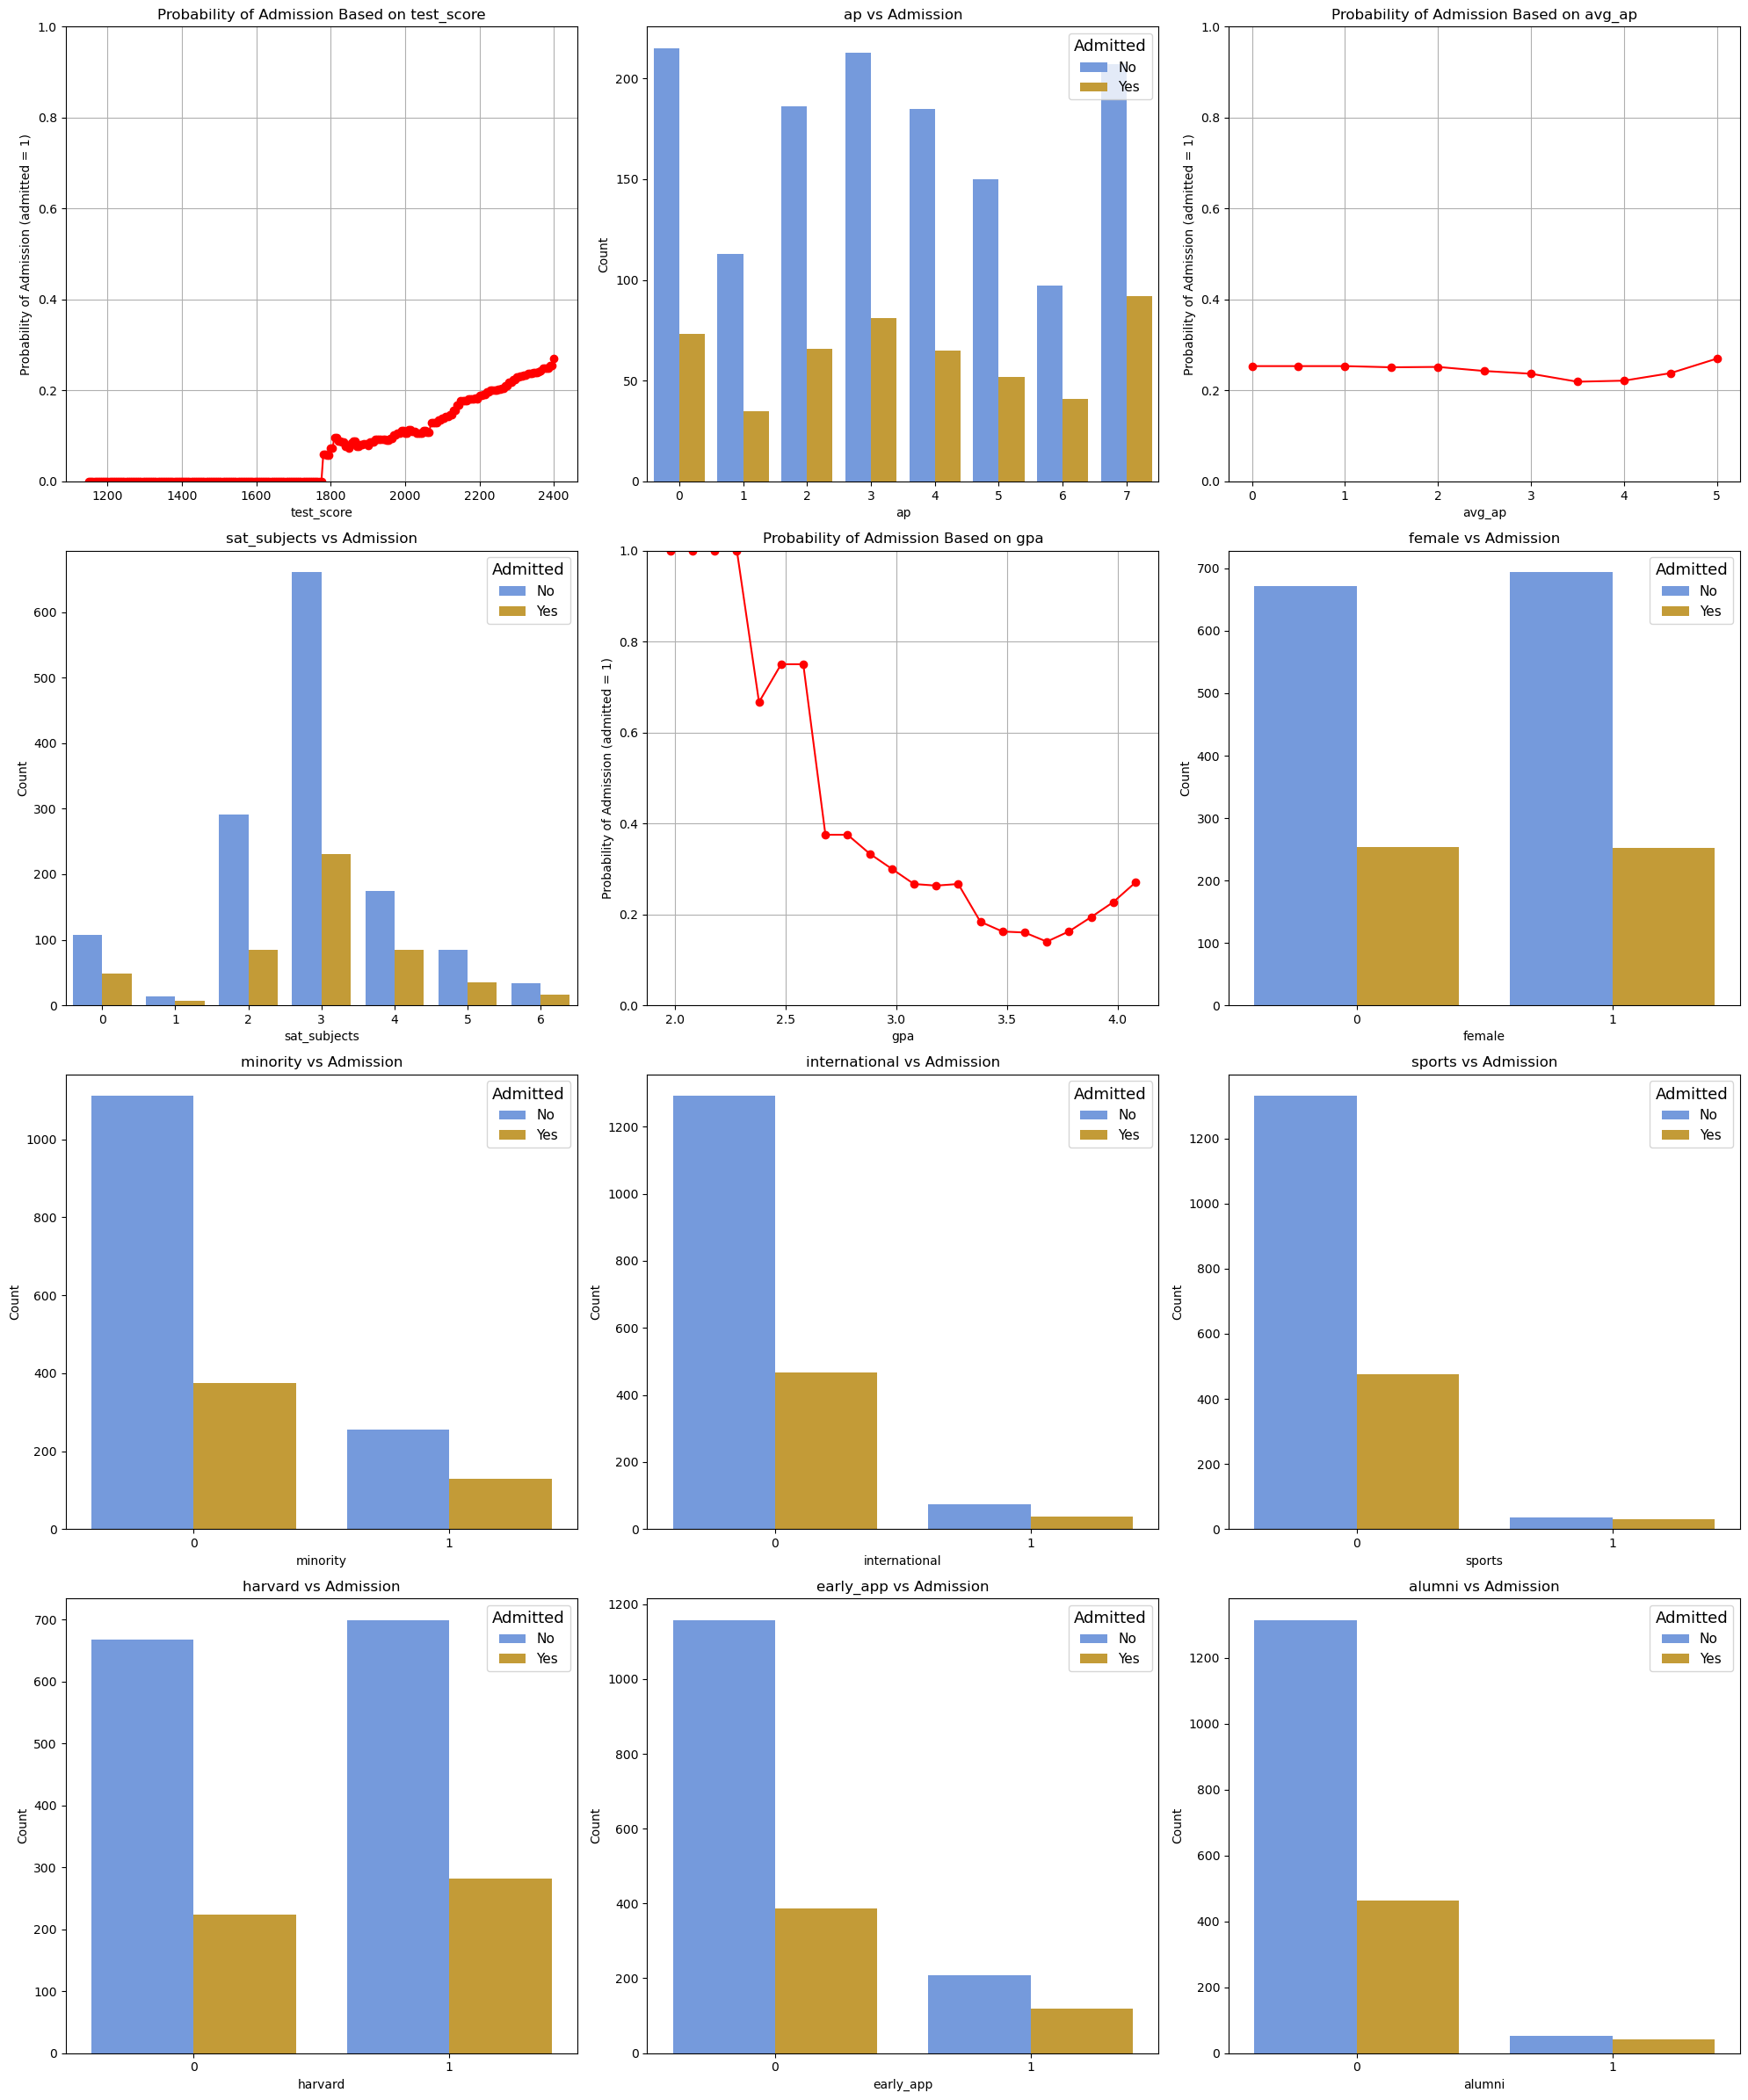

In [10]:
# Plotting
# your code here

# Set up the subplot grid
fig, axs = plt.subplots(4, 3, figsize=(20, 24))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Define consistent colors
colors = {0: 'cornflowerblue', 1: 'goldenrod'}
yn_labels = ['No', 'Yes']

# Function to calculate cumulative admission probability
def calc_cumulative_prob(data, variable, bins):
    probs = []
    for threshold in bins:
        subset = data[data[variable] <= threshold]
        prob = subset['admitted'].mean() if not subset.empty else 0
        probs.append(prob)
    return probs

# Define ranges for continuous variables
continuous_vars = {
    'test_score': np.arange(min(college['test_score']), 2405, 5),  # Assuming test scores range from 60 to 100
    'avg_ap': np.arange(min(college['avg_ap']), 5.1, 0.5),     # Average AP score range
    'gpa': np.arange(min(college['gpa']), 4.1, 0.1)       # GPA range
}

for i, predictor in enumerate(predictors):
    if predictor in ['test_score', 'avg_ap', 'gpa']:
        # Calculate cumulative probabilities and plot line graph
        bins = continuous_vars[predictor]
        probs = calc_cumulative_prob(college, predictor, bins)
        
        axs[i].plot(bins, probs, marker='o', linestyle='-', color='red')
        axs[i].set_title(f'Probability of Admission Based on {predictor}')
        axs[i].set_xlabel(predictor)
        axs[i].set_ylabel('Probability of Admission (admitted = 1)')
        axs[i].set_ylim(0, 1)
        axs[i].grid(True)
    else:
        # Bar plot for categorical variables
        sns.countplot(
            data=college, 
            x=predictor, 
            hue='admitted', 
            ax=axs[i],
            palette=colors,
            hue_order=[0, 1]  # Original order
        )
        axs[i].set_title(f'{predictor} vs Admission')
        axs[i].legend(title='Admitted', labels=yn_labels, title_fontsize='13', loc='best', fontsize='11')
        axs[i].set_ylabel('Count')

    axs[i].set_xlabel(predictor)

# Adjust layout and display the plot
plt.tight_layout()

## Testing to make sure the colors are accurate, and I understand what's happening with the probablity
# count1 = ((college['gpa'] >= 3.9) & (college['admitted'] == 1)).sum()
# count2 = ((college['female'] >= 1) & (college['admitted'] == 1)).sum()
# print(count1, count2)
# df = college[['admitted', 'gpa']]
# print(df[df['gpa'] <= 2.4])
# print(((college['alumni'] == 0) & (college['admitted'] == 1)).sum(), ((college['alumni'] == 0) & (college['admitted'] == 0)).sum())
# print(((college['alumni'] == 1) & (college['admitted'] == 1)).sum(), ((college['alumni'] == 0) & (college['admitted'] == 1)).sum())

# Calculate and print the possibilities
alumni_p = ((college['alumni'] == 1) & (college['admitted'] == 1)).sum() / len(college[college['alumni'] == 1])
no_alumni_p = ((college['alumni'] == 0) & (college['admitted'] == 1)).sum() / len(college[college['alumni'] == 0])

print(f'Probability of being admitted if alumni = 0 is {round(no_alumni_p,4)}')
print(f'Probability of being admitted if alumni = 1 is {round(alumni_p,4)}')


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Based on the visuals above, I believe the `alumni` predictor has the most potential for predicting admission. We can discern a clear relationship between `alumni` status and `admitted`: If you have a parent who is an alumnus of either Harvard or Yale, you are more likely to be admitted to these institutions.

A heuristic reason why I consider `alumni` to be potentially the best single predictor is that it may encompass other important factors. For example, if you have a parent who is an alumnus, you are likely to have a high `gpa`, achieve a high `test_score`, and complete numerous AP exams. As alumni of these prestigious schools, parents would likely know how to prepare their children for admission effectively.

As a result, we can observe that when an applicant has a parent who is an alumnus, the probability of being admitted approximately doubles.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>
    
**Q1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  
- Store the coefficient and intercept in `logit1_4_coef` and `logit1_4_intercept`. Interpret these values.
- Use $\LaTeX$ to demonstrate how you can use these coefficient values to calculate the estimated probabilities of getting into each school.
- Store the results of the above calculation in `p_harvard` and `p_yale`. 
- Which school is easier to get into according to this model?

**IMPORTANT:** 
- Remember, all models in this assignment should be **unregularized** unless you are specifically asked to use regularization for a particular model.
- Use `random_state = 109` for all of your `LogisticRegression` and `LogisticRegressionCV` models in this notebook.
</div>

In [11]:
# your code here
x1_4 = X_train[['harvard']]
# Fit logistic regression model without regularization
logit1_4 = LogisticRegression(penalty = None, 
                              fit_intercept=True, 
                              random_state = 109).fit(x1_4, y_train)

# Identify and report coefficients; work through the stupid formatting
logit1_4_coef = logit1_4.coef_[0][0]
logit1_4_intercept = logit1_4.intercept_[0]

# Calculate and report probabilities
p_harvard = 1 / (1 + np.exp(-1 * (logit1_4_intercept + logit1_4_coef)))
p_yale = 1 / (1 + np.exp(-logit1_4_intercept))

In [12]:
print(
    "The coefficient for the 'logit1_4' model's only predictor 'harvard' "
    "is {:.4f} and the intercept is {:.4f}\n".format(
        logit1_4_coef, logit1_4_intercept
    )
)

print(
    "Estimated probability of acceptance for Harvard: {:.4f}"
    .format(p_harvard)
)
print(
    "Estimated probability of acceptance for Yale: {:.4f}"
    .format(p_yale)
)

The coefficient for the 'logit1_4' model's only predictor 'harvard' is 0.2512 and the intercept is -1.1280

Estimated probability of acceptance for Harvard: 0.2938
Estimated probability of acceptance for Yale: 0.2445


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

If $\beta_0 =$ `logit1_4_coef` and $\beta_1 =$ `logit1_4_intercept` and

$$P(\texttt{admitted} = 1) = \frac{1}{1+e^{-(\beta_0+\beta_1X_{\textrm{Harvard}})}}:$$
Therefore,
$$ P(\texttt{admitted} = 1 | \texttt{harvard} = 1) = \frac{1}{1+e^{-(\beta_0+\beta_1)}}$$
$$\textrm{and } P(\texttt{admitted} = 1 | \texttt{harvard} = 0) = \frac{1}{1+e^{-\beta_0}}$$

From the results above, it would appear that **Harvard** is easier to get into (\~29\% vs \~24\%).

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [13]:
grader.check("q1.4")

q1.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.5** Create and display a [contingency table](https://en.wikipedia.org/wiki/Contingency_table) between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope). Show this calculation using $\LaTeX$ in a markdown cell.
    
**Hint:** The Pandas [crosstab](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) method may be helpful here.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

$$P(\texttt{admitted} = 1 | \texttt{harvard} = 1) = \frac{\text{Number of entries where }\texttt{admitted } = 1 \& \texttt{ harvard} = 1}{\text{Number of entries where } \texttt{harvard} = 1}$$
$$P(\texttt{admitted} = 1 | \texttt{harvard} = 1)=  \frac{228}{228+548} = 0.2938$$
Following a similar process for Yale applicants:
$$P(\texttt{admitted} = 1 | \texttt{harvard} = 0)=  \frac{176}{176+544} = 0.2444$$

We can use those probabilities to confirm the coefficients (below):

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_{\textrm{Harvard}} $$

For the intercept $\beta_0$:

$$ \ln \left( \frac{P(Y=1|X_{\textrm{Harvard}} = 0)}{1-P(Y=1|X_{\textrm{Harvard}} = 0)} \right) = \beta_0 \implies \beta_0 = \ln \left( \frac{0.2444}{1-0.2444} \right) \approx -1.1285$$

For the slope coefficient $\beta_1$:

$$ \ln \left( \frac{P(Y=1|X_{\textrm{Harvard}} = 1)}{1-P(Y=1|X_{\textrm{Harvard}} = 1)} \right) = \beta_0 + \beta_1 \implies \beta_1 = \ln \left( \frac{0.2938}{1-0.2938} \right) - (-1.1285) \approx 0.2515,$$

confirming our earlier computed coefficient estimates (to the third decimal place).

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [14]:
# your code here
# Create adnd display the contingency table
c_table1_4 = pd.crosstab(x1_4['harvard'], y_train)
c_table1_4

## Confirming the numbers
# print( ((college_train['harvard'] == 1) & (college_train['admitted'] == 1)).sum(), ((college_train['harvard'] == 0) & (college_train['admitted'] == 1)).sum()) 
# print( ((college_train['harvard'] == 1) & (college_train['admitted'] == 0)).sum(), ((college_train['harvard'] == 0) & (college_train['admitted'] == 0)).sum())

admitted,0,1
harvard,,
0,544,176
1,548,228


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2022-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In our earlier analysis, we found that the acceptance rate into either Harvard or Yale was above 20%, but the link shows that the acceptance rate into either school is below 5%. Clearly, there is a significant disparity between our calculated acceptance rate and the one reported by ivycoach.com.

I believe the driving force behind this discrepancy is the source of the samples. Ivycoach.com appears to use raw admissions data collected directly from the institutions, while CollegeData likely doesn't have access to that information. Upon examining CollegeData.com, it's evident that it's a college prep website.

Therefore, we are likely to see higher acceptance rates in the CollegeData sample because these are people with access to college prep materials, which not everyone represented in the ivycoach.com data might have. Consequently, the applicants in the CollegeData sample are probably more prepared than the average applicant. Moreover, the data from CollegeData.com was volunteered by students who had used that service. As a result, there may likely be a bias for students to report their successes, celebrating their achievements, while those who were not admitted might be less inclined to share their results.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part2"></a>

## <div class='exercise'>Question 2: Interpretable modeling</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q2.1** 
    
- Fit a logistic regression model to predict `admitted` from `test_score` alone. Call it `logit2_1`.
- Store the learned parameters in `logit2_1_intercept` and `logit2_1_coef_test_score`. 
- Store the train accuracy and mean 10-fold cross-validation accuracy in `acc_train_logit2_1` and `acc_cv_logit2_1`.

**Note:** The coefficients and train accuracies should come from a model fit on all the training data. To calculate the mean 10-fold cross-validation accuracy, use `cross_val_score`. This should be the strategy used throughout the notebook except when using `LogisticRegressionCV` in later questions (since this model already gives you CV scores "for free"). Will will assume 10 folds whenever we cross-validate in this notebook.
</div>

In [15]:
# your code here
# Create and fit the logistic regression model
logit2_1 = LogisticRegression(
    fit_intercept=True,
    random_state=109
).fit(X_train[['test_score']], y_train)

# Create and store the intercept and coefficient values
logit2_1_intercept = logit2_1.intercept_[0]
logit2_1_coef_test_score = logit2_1.coef_[0][0]

# Store the accuracy values
acc_train_logit2_1 = logit2_1.score(X_train[['test_score']], y_train)
acc_cv_logit2_1 = cross_val_score(logit2_1,
                                    X = X_train[['test_score']],
                                    y = y_train,
                                    cv=10,
                                    ).mean()

In [16]:
print("The intercept and coefficient for the 'logit2_1' model are:")

print("\t{:<20}{:.4f}".format('intercept', logit2_1_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_1_coef_test_score))

print(
    "\nThe classification accuracies for 'logit2_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}".format(
        acc_train_logit2_1, acc_cv_logit2_1
    )
)

The intercept and coefficient for the 'logit2_1' model are:
	intercept           -10.5474
	test_score          0.0043

The classification accuracies for 'logit2_1' are:

	Train	0.7299
	CV	0.7300


In [17]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<div class='exercise-r'>

**Q2.2**
    
- What is the estimated probability of an applicant being admitted with a `test_score` of 2250? Store this in `prob_test_2250`.
- What about if they had a perfect test score of 2400? Store this in `prob_test_2400`.
- What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted? Store this in `test_50_50`.
    
</div>

In [18]:
# your code here
prob_test_2250 = 1 / (1 + np.exp(-1 * (logit2_1_intercept + logit2_1_coef_test_score * 2250)))
prob_test_2400 = 1 / (1 + np.exp(-1 * (logit2_1_intercept + logit2_1_coef_test_score * 2400)))

test_50_50 = float(- (logit2_1_intercept / logit2_1_coef_test_score))

In [19]:
print(
    "The estimated chances of an applicant being admitted with "
    "the following two 'test' scores:\n\n\tscore\tprobabilities"
    "\n\t2250\t{:.4f}\n\t2400\t{:.4f}\n"
    .format(prob_test_2250, prob_test_2400)
)

print(
    "The test score required to have a 50-50 chance of being "
    "admitted is approximately:\n\n\t{:.2f}"
    .format(test_50_50)
)

The estimated chances of an applicant being admitted with the following two 'test' scores:

	score	probabilities
	2250	0.3019
	2400	0.4525

The test score required to have a 50-50 chance of being admitted is approximately:

	2444.20


In [20]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<div class='exercise-r'>

**Q2.3** Fit a logistic regression model to predict `admitted` from `test_score` and `avg_ap` (call it `logit2_3`).  Store the train and mean cv accuracies calculated as before in `acc_train_logit2_3` and `acc_cv_logit2_3`. Then use the provided code to print out the coefficient estimates along with the accuracy scores.
    
</div>

In [21]:
# your code here
# Create the dataset
X_train2_3 = X_train[['test_score', 'avg_ap']]

# Create and fit the logistic regression model
logit2_3 = LogisticRegression(
    penalty=None,
    fit_intercept=True,
    random_state=109
).fit(X_train2_3, y_train)

# Create and store intercept and coefficient values
logit2_3_intercept = logit2_3.intercept_[0]
logit2_3_coef_test_score = logit2_3.coef_[0][0]
logit2_3_coef_avg_ap = logit2_3.coef_[0][1]

# Store the accuracy values
acc_train_logit2_3 = logit2_3.score(X_train2_3, y_train)
acc_cv_logit2_3 = cross_val_score(logit2_3,
                                    X = X_train2_3,
                                    y = y_train,
                                    cv=10,
                                    ).mean()

In [22]:
# Print the results of logit2_3
print("The intercept and coefficients for the 'logit2_3' model are:")
print("\t{:<20}{:.4f}".format('intercept', logit2_3_intercept))
print("\t{:<20}{:.4f}".format('test', logit2_3_coef_test_score))
print("\t{:<20}{:.4f}".format('avg_ap', logit2_3_coef_avg_ap))

print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_3, acc_cv_logit2_3)
)

The intercept and coefficients for the 'logit2_3' model are:
	intercept           -10.9086
	test                0.0046
	avg_ap              -0.0723

The classification accuracies for 'logit2_3' are:

	Train	0.7306
	CV	0.7299


In [23]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test_score` to the one from `logit2_1`.  Why has this estimate changed?

You should inspect the relationship between `test_score` and `avg_ap` to help get a better sense for what might be happening here.

</div>

In [24]:
# Print the parameters of the last 2 models
print("The intercept and coefficient for the 'logit2_1' model are:")

print("\t{:<20}{:.4f}".format('intercept', logit2_1_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_1_coef_test_score))

print("The intercept and coefficients for the 'logit2_3' model are:")
print("\t{:<20}{:.4f}".format('intercept', logit2_3_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_3_coef_test_score))
print("\t{:<20}{:.4f}".format('avg_ap', logit2_3_coef_avg_ap))

The intercept and coefficient for the 'logit2_1' model are:
	intercept           -10.5474
	test_score          0.0043
The intercept and coefficients for the 'logit2_3' model are:
	intercept           -10.9086
	test_score          0.0046
	avg_ap              -0.0723


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

For the `logit2_3` model, an `avg_ap` of -0.0723 suggests that for every 1-point increase in avg_ap (AP score), the log-odds of admission decrease by 0.0723 while holding all other variables constant. This suggests that higher AP scores decrease the odds of admission which is counter-intuitive given that one might expect that a better AP score is correlated with overall academic performance which is a large factor in college admissions.

Contrastingly, for the `logit2_3` model, `test_score` of 0.0046 suggests that for every 1-point increase in test_score (SAT score), the log-odds of admission increase by 0.0046 while holding all other variables constant. This means that higher SAT scores increase the odds of admission which follows logic, albeit the effect being relatively small.

Our findings suggest that `avg_ap` and `test_score` influence the likelihood of admissions in different directions which is contrary to what one might expect given that both the APs and SAT/ACT are used to gauge academic rigor in similar ways before college.

For as to why we see a slight increase in the `test_score` coefficient between the `logit2_1` and `logit2_3` models (0.0043 and 0.0046 respectively), one could argue that this is because of the `logit2_3` model's introduction of a potentially relative predictor in `avg_ap`. There could potentially be some correlation between admission likelihood/`test_score` and `avg_ap`; as such, when `avg_ap` is introduced to our model it could alleviate poptentially confounding  happening in the `logit2_1` model.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [25]:
# your code here
X_train2_3.corr()

,test_score,avg_ap
test_score,1.000,0.388
avg_ap,0.388,1.000


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q2.5** Interpret and compare the train and cv accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.

</div>

In [26]:
# Display accuracies of last 2 models
print(
    "\nThe classification accuracies for 'logit2_1' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_1, acc_cv_logit2_1)
)
print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_3, acc_cv_logit2_3)
)


The classification accuracies for 'logit2_1' are:

	Train	0.7299
	CV	0.7300

The classification accuracies for 'logit2_3' are:

	Train	0.7306
	CV	0.7299


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

As a reminder, `logit2_1` was our logistic regression model using only `test_score` as a predictor, while `logit2_3` was our logistic regression model using both `test_score` and `avg_ap`.

The accuracy metric tells us the percentage of data points the model correctly classified. The train accuracy indicates how well the model classifies the training data as is, while the CV accuracy shows how well the model classified the training data under 10-fold cross-validation, taking the mean of its accuracies across the folds.

Both `logit2_1` and `logit2_3` have nearly identical train and CV accuracies, correctly classifying approximately 73% of the data. The primary reason for this similarity might be that `test_score` and `avg_ap` are highly correlated. For instance, if an applicant we're examining has a high `test_score`, they are also likely to have a high `avg_ap` (and vice versa). We can reasonably assume this correlation exists because AP exams are typically graded based on standardized tests.

Consequently, our model doesn't gain significant new information from `avg_ap` to alter its predictions. In essence, the predictive power from `avg_ap` has already been captured by the predictive power of `test_score`. It's as if `test_score` and `avg_ap` are interchangeable in terms of their predictive capability in this context.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part3"></a>

## <div class='exercise'>Question 3: Harvard and Yale?</div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.1**
- Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test_score", "ap", "avg_ap", "gpa", "female", "minority"]`.
- Store the train and mean cv accuracies in `acc_train_logit3_1` and `acc_cv_logit3_1`.
- Interpret the coefficients for the binary predictors in this model.

**Hint:**
- If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [27]:
# Print statements below assume predictors used in this order
logit3_1_predictors = ["harvard", "test_score", "ap", "avg_ap", "gpa", "female", "minority"]

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The binary predictors that we use in our model are `harvard`, `female` and `minority`. 

The regression coefficient for `harvard` is 0.2578 suggests that if a student applied to harvard, the log-odds of admission increase by 0.2578 while holding all other variables constant. This further implies something about acceptance rates between those who apply to Yale vs Harvard as it appears not applying to Harvard does not better/worsens one's college admission chances.

The regression coefficient for `female` is -0.0490 suggests that if a student is female, the log-odds of admission decrease by 0.0490 while holding all other variables constant. As such, one could conclude from the data that a student's admission likelihood is lower if they identify as female.

The regression coefficient for `minority` is 0.7709 suggests that if a student identifes as being a member of a minority, the log-odds of admission increase by 0.7709 while holding all other variables constant. One reason for this noticeable admission likelihood increase for students who identify as minority members could be affirmative action policies.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [28]:
# your code here
X_train_3_1 = X_train[logit3_1_predictors]
logit3_1 = LogisticRegression(
    penalty=None,
    fit_intercept=True,
    random_state=109,
    n_jobs=-1,
    max_iter=1000
).fit(X_train_3_1, y_train)
acc_train_logit3_1 = logit3_1.score(X_train_3_1,y_train)
acc_cv_logit3_1 = cross_val_score(logit3_1,
                                    X = X_train_3_1,
                                    y = y_train,
                                    cv=10,
                                    n_jobs=-1
                                    ).mean()

In [29]:
# Grab model's intercept and coefs regardless of their shape
# (which depends on how x and y were shaped)
logit3_1_intercept = np.array(logit3_1.intercept_).flatten()[0]
logit3_1_coefs = logit3_1.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_1' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_1_intercept
    )
)
for predictor, coef in zip(logit3_1_predictors, logit3_1_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit3_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_1, acc_cv_logit3_1)
)

The intercept and coefficients for the 'logit3_1' model are:

	intercept           -13.2385
	harvard             0.2578
	test_score          0.0052
	ap                  -0.0484
	avg_ap              -0.0304
	gpa                 0.2152
	female              -0.0490
	minority            0.7709

The classification accuracies for 'logit3_1' are:

	Train	0.7353
	CV	0.7300


In [30]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- END QUESTION -->

<div class='exercise-r'>

**Q3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test_score", "ap"]` along with the 2 interaction terms: `harvard` with `test_score` and `harvard` with `ap`. Name the columns for these interaction terms `harvard_test_score` and `harvard_ap`. Store the train and mean cv accuracies in `acc_train_logit3_2` and `acc_cv_logit3_2`.

</div>

In [31]:
# Print statement below assumes this order of predictors
logit3_2_predictors = ["harvard", "test_score", "ap", "harvard_test_score", "harvard_ap"]

In [32]:
# your code here
X_train_3_1['harvard_test_score'] = X_train_3_1['harvard'] * X_train_3_1['test_score']
X_train_3_1['harvard_ap'] = X_train_3_1['harvard'] * X_train_3_1['ap']
X_train_3_2 = X_train_3_1[logit3_2_predictors]
logit3_2 = LogisticRegression(
    penalty=None,
    fit_intercept=True,
    random_state=109,
    n_jobs=-1,
    max_iter=1000
).fit(X_train_3_2, y_train)

acc_train_logit3_2 = logit3_2.score(X_train_3_2,y_train)
acc_cv_logit3_2 = acc_cv_logit3_1 = cross_val_score(logit3_2,
                                    X = X_train_3_2,
                                    y = y_train,
                                    cv=10,
                                    n_jobs=-1
                                    ).mean()

/var/folders/g0/24qwcrld4nb_zw_4mfnl5n240000gn/T/ipykernel_4718/4145869470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_3_1['harvard_test_score'] = X_train_3_1['harvard'] * X_train_3_1['test_score']
/var/folders/g0/24qwcrld4nb_zw_4mfnl5n240000gn/T/ipykernel_4718/4145869470.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_3_1['harvard_ap'] = X_train_3_1['harvard'] * X_train_3_1['ap']


In [33]:
# Print results of logit3_2
logit3_2_intercept = np.array(logit3_2.intercept_).flatten()[0]
logit3_2_coefs = logit3_2.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_2' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_2_intercept
    )
)

for predictor, coef in zip(logit3_2_predictors, logit3_2_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))
    
print(
    "\nThe classification accuracies for 'logit3_2' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_2, acc_cv_logit3_2)
)

The intercept and coefficients for the 'logit3_2' model are:

	intercept           -9.8464
	harvard             -2.0378
	test_score          0.0039
	ap                  0.0048
	harvard_test_score  0.0012
	harvard_ap          -0.1045

The classification accuracies for 'logit3_2' are:

	Train	0.7360
	CV	0.7353


In [34]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants:
1. someone who is applying to Harvard
2. someone who is applying to Yale (keep `test_score` and `ap` as the unknown $X$s).

The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$
    
**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$. Show all your steps, not just the final result.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

For someone who is applying to Harvard ($X_{harvard} = 1$):
$$ \ln \left( \frac{P(Y=1|X_{harvard} = 1)}{1-P(Y=1|X_{harvard} = 1)} \right) = \beta_0 + \beta_{harvard}*1 + \beta_{ap} X_{ap} + \beta_{test\_score} X_{test\_score} + \beta_{harvard\_ap}*1*X_{ap} + \beta_{harvard\_test\_score}*1*X_{test\_score}$$
$$ \ln \left( \frac{P(Y=1|X_{harvard} = 1)}{1-P(Y=1|X_{harvard} = 1)} \right) = \beta_0 + \beta_{harvard} + (\beta_{ap} + \beta_{harvard\_ap})X_{ap} + (\beta_{test\_score} + \beta_{harvard\_test\_score})X_{test\_score}$$

Let $k = \beta_0 + \beta_{harvard} + (\beta_{ap} + \beta_{harvard\_ap})X_{ap} + (\beta_{test\_score} + \beta_{harvard\_test\_score})X_{test\_score}$.

$$ e^{\ln \left( \frac{P(Y=1|X_{harvard} = 1)}{1-P(Y=1|X_{harvard} = 1)} \right)} = e^{k}$$
$$ \frac{P(Y=1|X_{harvard} = 1)}{1-P(Y=1|X_{harvard} = 1)} = e^{k}$$
$$ P(Y=1|X_{harvard} = 1) = e^{k} * (1-P(Y=1|X_{harvard} = 1))$$
$$ P(Y=1|X_{harvard} = 1) * (1 + e^{k}) = e^{k}$$
$$ P(Y=1|X_{harvard} = 1) = \frac{e^{k}}{1 + e^{k}}$$
$$ P(Y=1|X_{harvard} = 1) = \frac{e^{-9.8464 - 2.0378 + (0.0048 - 0.1045)X_{ap} + (0.0039 +  0.0012)X_{test\_score}}}{1 + e^{-9.8464 - 2.0378 + (0.0048 - 0.1045)X_{ap} + (0.0039 +  0.0012)X_{test\_score}}}$$
$$ P(Y=1|X_{harvard} = 1) = \frac{e^{-11.8842 - 0.0997X_{ap} + 0.0051X_{test\_score}}}{1 + e^{-11.8842 - 0.0997X_{ap} + 0.0051X_{test\_score}}}$$

For someone who is applying to Yale ($X_{harvard} = 0$):
$$ \ln \left( \frac{P(Y=1|X_{harvard} = 0)}{1-P(Y=1|X_{harvard} = 0)} \right) = \beta_0 + \beta_{harvard} * 0 + \beta_{ap} X_{ap} + \beta_{test\_score} X_{test\_score} + \beta_{harvard\_ap}*0*X_{ap} + \beta_{harvard\_test\_score}*0*X_{test\_score}$$
$$ \ln \left( \frac{P(Y=1|X_{harvard} = 0)}{1-P(Y=1|X_{harvard} = 0)} \right) = \beta_0 + \beta_{ap} X_{ap} + \beta_{test\_score} X_{test\_score}$$

Let $m = \beta_0 + \beta_{ap} X_{ap} + \beta_{test\_score} X_{test\_score}$
$$ e^{\ln \left( \frac{P(Y=1|X_{harvard} = 0)}{1-P(Y=1|X_{harvard} = 0)} \right)} = e^{m}$$
$$ \frac{P(Y=1|X_{harvard} = 0)}{1-P(Y=1|X_{harvard} = 0)} = e^{m}$$
$$ P(Y=1|X_{harvard} = 0) = e^{m} * (1-P(Y=1|X_{harvard} = 0))$$
$$ P(Y=1|X_{harvard} = 0) * (1 + e^{m}) = e^{m}$$
$$ P(Y=1|X_{harvard} = 0) = \frac{e^{m}}{1 + e^{m}}$$
$$ P(Y=1|X_{harvard} = 0) = \frac{e^{-9.8464 + 0.0048X_{ap} + 0.0039X_{test\_score}}}{1 + e^{-9.8464 + 0.0048X_{ap} + 0.0039X_{test\_score}}}$$

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test_score` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied to? 

Use the function for Harvard to answer the following question: if a student scored a perfect 2400 on `test_score`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

Again, you should show your work in $\LaTeX$.
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

For Harvard: 
$$\ln(1) = -11.8842 - 0.0997X_{ap} + 0.0051X_{test\_score}$$
$$0 = -11.8842 - 0.0997X_{ap} + 0.0051X_{test\_score}$$
$$X_{test\_score} = \frac{11.8842 + 0.0997X_{ap}}{0.0051}$$
$$X_{test\_score} = 19.5490X_{ap} + 2330.2352$$

Any `test_score` in the range (2330.2352, 2400] can achieve a better than 50% chance of being admitted to Harvard.

For Yale: 
$$\ln(1) = -9.8464 + 0.0048X_{ap} + 0.0039X_{test\_score}$$
$$0 = -9.8464 + 0.0048X_{ap} + 0.0039X_{test\_score}$$
$$X_{test\_score} = \frac{9.8464 - 0.0048X_{ap}}{0.0039}$$
$X_{test\_score} = -1.2307X_{ap} + 2524.7179$$


Any `test_score` in the range [0, 2400] can achieve a better than 50% chance of being admitted to Yale. However I will note that even for the perfect score of 2400, an unreasoanble number of APs would have to be taken to achieve this (102 APs).

If a student has a perfect `test_score`:
$$X_{test\_score} = 19.5490X_{ap} + 369.4509$$
$$2400 = 19.5490X_{ap} + 2330.23529$$
$$X_{ap} = 3.5687$$

Taking more than 4 `ap` classes would be needed to have a greater than 50% chance of being admitted to Harvard.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test_score` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous question (Q3.4).  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see. You might try 'dithering' the points with a random offset so they are not all on top of one another.
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The plots illustrate the admissions data for Harvard and Yale, showing the relationship between AP classes and test scores, with decision boundaries supposedly dividing the admitted and not admitted students. For Harvard, the decision boundary is a slightly upward-sloping line, indicating a positive correlation between APs taken and test scores for admissions. The data points reveal a somewhat discernible separation: a higher proportion of the total students above the line are admitted students (green), then the proportion of admitted students below the line. This suggests that higher test scores relative to number of AP classes are a significant factor in Harvard's admission decisions.

In contrast, Yale's decision boundary is nearly horizontal, suggesting a weaker relationship between AP classes and test scores. Furthermore, the distribution of data points are clearly below the boundary, with both admitted and not admitted students scattered below the boundary line. This indicates that Yale's admissions may rely more on factors beyond just APs and test scores, as the separation between different groups is less pronounced compared to Harvard. 

Overall, the plots highlight the differing emphasis on academic metrics in the admissions processes of these two institutions. Harvard seems to be more lenient on your test scores if you have taken fewer AP classes, especially in comparison to Yale.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

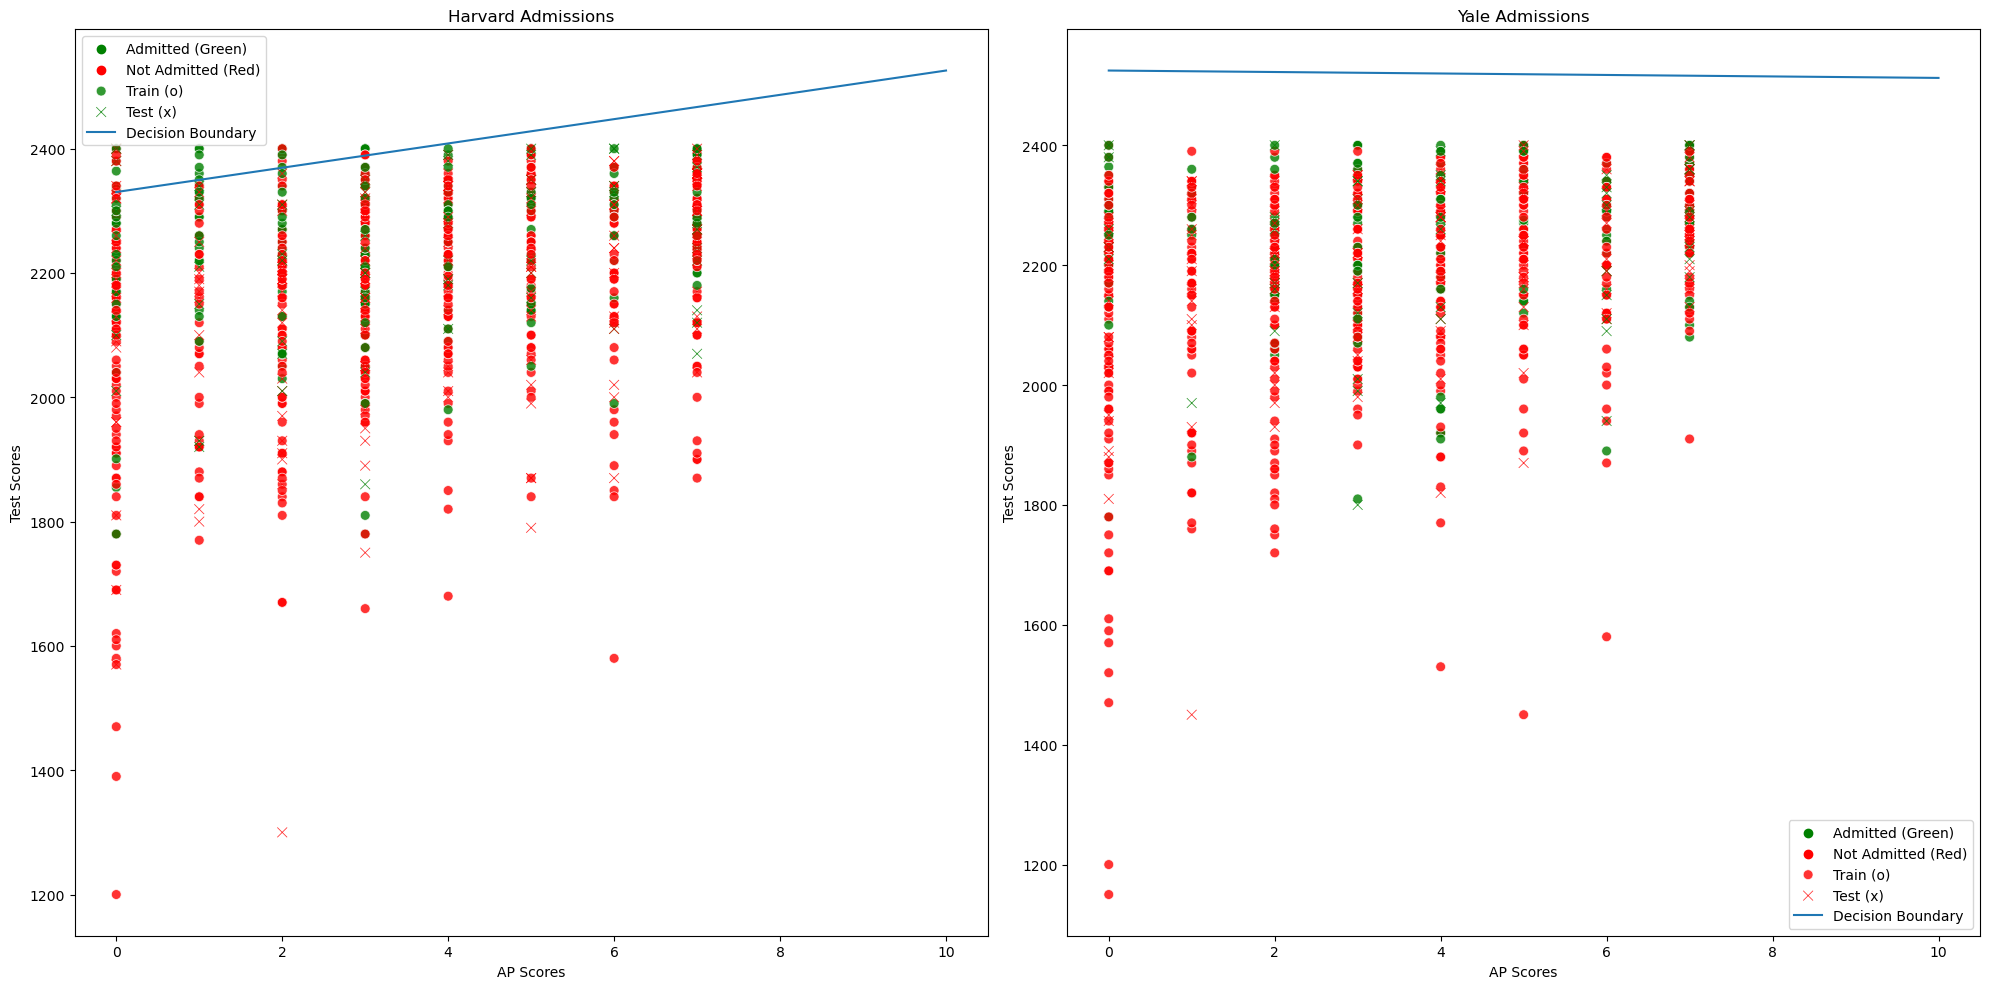

In [35]:
# your code here
def harvard_boundary(ap):
    return (11.8842 + 0.0997 * ap) / 0.0051

def yale_boundary(ap):
    return (9.8464 - 0.0048 * ap) / 0.0039

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Separate data by institution
harvard_data_train = college_train[college_train['harvard'] == 1]
harvard_data_test = college_test[college_test['harvard'] == 1]
yale_data_train = college_train[college_train['harvard'] == 0]
yale_data_test = college_test[college_test['harvard'] == 0]

# Define boundary line range
boundary_x = np.linspace(0, 10, 100)

# Plot for Harvard
axes[0].scatter([], [], color='green', label='Admitted (Green)')
axes[0].scatter([], [], color='red', label='Not Admitted (Red)')
sns.scatterplot(data=harvard_data_train, x='ap', y='test_score',
                c=['red' if y == 0 else 'green' for y in y_train[X_train['harvard'] == 1]], 
                ax=axes[0], marker='o', s=50, alpha=0.8, label='Train (o)')
sns.scatterplot(data=harvard_data_test, x='ap', y='test_score', 
                c=['red' if y == 0 else 'green' for y in y_test[X_test['harvard'] == 1]], 
                ax=axes[0], marker='x', s=50, alpha=0.8, label='Test (x)')
axes[0].plot(boundary_x, harvard_boundary(boundary_x), label='Decision Boundary')
axes[0].set_title('Harvard Admissions')
axes[0].set_xlabel('AP Scores')
axes[0].set_ylabel('Test Scores')
axes[0].legend()

# Plot for Yale
axes[1].scatter([], [], color='green', label='Admitted (Green)')
axes[1].scatter([], [], color='red', label='Not Admitted (Red)')
sns.scatterplot(data=yale_data_train, x='ap', y='test_score',
                c=['red' if y == 0 else 'green' for y in y_train[X_train['harvard'] == 0]], 
                ax=axes[1], marker='o', s=50, alpha=0.8, label='Train (o)')
sns.scatterplot(data=yale_data_test, x='ap', y='test_score', 
                c=['red' if y == 0 else 'green' for y in y_test[X_test['harvard'] == 0]], 
                ax=axes[1], marker='x', s=50, alpha=0.8, label='Test (x)')
axes[1].plot(boundary_x, yale_boundary(boundary_x), label='Decision Boundary')
axes[1].set_title('Yale Admissions')
axes[1].set_xlabel('AP Scores')
axes[1].set_ylabel('Test Scores')
axes[1].legend()

fig.tight_layout()
plt.show()

In [36]:
# your code here
...

<!-- END QUESTION -->

<div class='exercise-r'>

**Q3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test_score", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`. 

 - Store the train and mean cv accuracies in `acc_train_logit3_6` and `acc_cv_logit3_6`.
 - Display the accuracy scores.
</div>

In [37]:
# Provided code in Q3.7 will assume this order of predictors
logit3_6_predictors = ["harvard",
                       "test_score",
                       "female",
                       "minority",
                       "harvard_female",
                       "harvard_minority"
                      ]

In [38]:
# your code here
X_train_3_1['harvard_female'] = X_train_3_1['harvard'] * X_train_3_1['female']
X_train_3_1['harvard_minority'] = X_train_3_1['harvard'] * X_train_3_1['minority']
X_train_3_6 = X_train_3_1[logit3_6_predictors]
logit3_6 = LogisticRegression(
    penalty=None,
    fit_intercept=True,
    random_state=109,
    n_jobs=-1,
    max_iter=1000
).fit(X_train_3_6, y_train)
acc_train_logit3_6 = logit3_6.score(X_train_3_6,y_train)
acc_cv_logit3_6 = cross_val_score(logit3_6,
                                    X = X_train_3_6,
                                    y = y_train,
                                    cv=10,
                                    n_jobs=-1
                                    ).mean()

/var/folders/g0/24qwcrld4nb_zw_4mfnl5n240000gn/T/ipykernel_4718/785555651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_3_1['harvard_female'] = X_train_3_1['harvard'] * X_train_3_1['female']
/var/folders/g0/24qwcrld4nb_zw_4mfnl5n240000gn/T/ipykernel_4718/785555651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_3_1['harvard_minority'] = X_train_3_1['harvard'] * X_train_3_1['minority']


In [39]:
print(
    "\nThe classification accuracies for 'logit3_6' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_6, acc_cv_logit3_6)
)


The classification accuracies for 'logit3_6' are:

	Train	0.7353
	CV	0.7279


In [40]:
grader.check("q3.6")

q3.6 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).
    
</div>

In [41]:
# Display results
logit3_6_intercept = np.array(logit3_6.intercept_).flatten()[0]
logit3_6_coefs = logit3_6.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_6' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_6_intercept
    )
)

for predictor, coef in zip(logit3_6_predictors, logit3_6_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

The intercept and coefficients for the 'logit3_6' model are:

	intercept           -12.0758
	harvard             0.2784
	test_score          0.0049
	female              -0.1541
	minority            1.0975
	harvard_female      0.2329
	harvard_minority    -0.6182


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The regression coefficient for `female` is -0.1541 suggests that if a student is female, the log-odds of admission decrease by 0.1541 while holding all other variables constant. As such, one could conclude from the data that a student's admission likelihood is lower if they identify as female.

The regression coefficient for `minority` is 1.0975 suggests that if a student identifes as being a member of a minority, the log-odds of admission increase by 1.0975 while holding all other variables constant. One reason for this noticeable admission likelihood increase for students who identify as minority members could be affirmative action policies.

The regression coefficient for `harvard_female` is 0.2329 suggests that if a student is female and applied to harvard, the log-odds of admission increase by 0.2329 while holding all other variables constant. This is slightly less strong of an increase than that applied from the `harvard` coefficient alone, and this could be explained by the decreasing effect that the `female` coefficient has on admission likelihood.

The regression coefficient for `harvard_minority` is -0.6182 suggests that if a student identifies as a minority member and applied to harvard, the log-odds of admission decrease by 0.6182 while holding all other variables constant. Notably, this interaction term coefficient causes a significant decrease in admission likelihood relative to our previous model's `minority` coefficient. When assessing, the positive effect of `minority` coefficient alone one could be led to believe that admission likelihood is quite obviously positively correlated, but clearly there is more to the story.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.8** Based on this model, how does it appear that Harvard and Yale compare in admitting women and minorities?  Given what we've seen in our previous analysis, what might be some reasons we have to doubt the interpretation of the model's coefficients as reflecting the truth?

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Based on the logit3_6 model, it appears that Harvard and Yale differ in how gender and minority status influence admission likelihood. For female applicants, the negative main effect coefficient for female (-0.1541) suggests that at Yale (the baseline institution when harvard = 0), being female slightly decreases the odds of admission. However, the positive interaction term between harvard and female (0.2329) indicates that at Harvard, this disadvantage is not only mitigated but slightly reversed. This means that at Harvard, female applicants have a modest increase in admission odds compared to male applicants, implying that Harvard may be more favorable toward female applicants than Yale.

For minority applicants, the substantial positive main effect coefficient for minority (1.0975) implies that at Yale, being an under-represented minority significantly increases the odds of admission. The negative interaction term between harvard and minority (-0.6182) indicates that this positive effect is lessened at Harvard. In other words, while minority status greatly boosts admission odds at Yale, this advantage is reduced at Harvard, suggesting that Yale may place a stronger emphasis on minority status in its admissions process compared to Harvard.

However, we have reasons to be cautious about interpreting these coefficients as absolute truths. First, collinearity between predictors (e.g., test_score, female, minority) might distort the estimated effects, making it difficult to isolate the impact of each variable accurately. Second, the model may suffer from omitted variable bias since important factors like extracurricular activities, personal statements, recommendation letters, and socioeconomic background are not included but could significantly influence admissions decisions. Third, the sample data might not be fully representative of the entire applicant pools for both universities, leading to biased estimates. Additionally, the relatively small differences in classification accuracies and the potential for statistical noise mean that the observed effects might not be practically significant. Lastly, the interaction terms complicate the interpretation; the negative interaction for minorities at Harvard could be due to chance or other unmeasured factors rather than a deliberate policy difference.

Given these considerations, while the model suggests certain trends in how Harvard and Yale admit women and minorities, we should be cautious in accepting these findings at face value. Further analysis with more comprehensive data and consideration of additional variables would be necessary to draw definitive conclusions.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part4"></a>

## <div class='exercise'>Question 4: Building predictive models for admitted</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test_score` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. 

1. Explain why scaling under these circumstances might be important.
2. Define a list of all non-binary predictors from the original set of 12 predictors, calling it `non_binary_predictors`.
3. Apply standardized scaling to all of these **non-binary** predictors. **For the sake of consistency, fit your scaler on just the training data. Then use it to transform both train and test.**

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set. Tests from this point on assume that `X_train` and `X_test` have been standardized with the approach outlined above. 

</div>

Scaling predictors is crucial for regularized regression and distance-based algorithms like k-NN classification due to several important reasons. 

Firstly, it ensures that all features contribute equally to the model, preventing those with larger scales from dominating the learning process. This is particularly important when dealing with predictors that vary greatly in magnitude, such as test scores in the thousands versus smaller-scale variables. 

Scaling allows for more appropriate regularization parameters by ensuring that penalties are applied uniformly across features, regardless of their original scale. This prevents features with larger scales from being overly penalized and allows for a more balanced trade-off between model complexity and overfitting prevention.

Lastly, for distance-based algorithms like k-NN, scaling is essential to prevent features with larger scales from having a disproportionate influence on distance calculations. Without scaling, the algorithm might overly prioritize features with larger numeric ranges, potentially leading to biased or inaccurate classifications. 

By putting all predictors on a similar scale, we ensure a more balanced and fair contribution of each feature to the model's decision-making process, ultimately leading to more reliable and interpretable results.

In [42]:
# your code here
# 2. Define list of non-binary predictors
non_binary_predictors = ['test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa']

# Initialize Standard Scaler
scaler = StandardScaler().fit(X_train[non_binary_predictors])

# Transform both train and test data
X_train[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
X_test[non_binary_predictors] = scaler.transform(X_test[non_binary_predictors])

In [43]:
# preview summary stats after standardizing
X_train.describe()

,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,harvard
count,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000
mean,5.343e-16,3.800e-17,1.639e-16,1.615e-16,-4.180e-16,0.511,0.215,0.061,0.035,0.172,0.046,0.519
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,0.500,0.411,0.239,0.185,0.378,0.210,0.500
min,-6.125e+00,-1.470e+00,-2.159e+00,-2.262e+00,-9.703e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-4.540e-01,-6.091e-01,-1.203e-01,-6.917e-01,-2.008e-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.958e-01,-1.787e-01,4.205e-01,9.342e-02,3.612e-01,1.000,0.000,0.000,0.000,0.000,0.000,1.000
75%,7.275e-01,6.822e-01,6.909e-01,9.342e-02,6.167e-01,1.000,0.000,0.000,0.000,0.000,0.000,1.000
max,1.259e+00,1.543e+00,7.533e-01,2.449e+00,6.167e-01,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [44]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = range(1, 50, 2)` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, store your chosen $k$ in `best_k`, the accuracy on the best model when refit on all the training data in `knn_train_acc`, and the mean 10-fold CV accuracy of the best model in `knn_cv_acc`.
    
</div>

In [45]:
predictor_list = [
    "test_score", "ap", "avg_ap", "sat_subjects",
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]

ks = range(1, 50, 2)
training_score = []
validation_score = []

# your code here
for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors=k,
                                     n_jobs=-1,
                                    ).fit(X_train[predictor_list],y_train)
    score = cross_validate(knn_model,
                          X = X_train[predictor_list],
                          y = y_train,
                          cv = 10,
                          n_jobs = -1,
                          return_train_score=True,
                          scoring = 'accuracy')
    training_score.append(score['train_score'].mean())
    validation_score.append(score['test_score'].mean())

best_k = ks[np.argmax(validation_score)]

knn_model = KNeighborsClassifier(n_neighbors=best_k,
                                     n_jobs=-1,
                                    ).fit(X_train[predictor_list],y_train)

knn_train_acc = knn_model.score(X_train[predictor_list],y_train)
knn_cv_acc = max(validation_score)

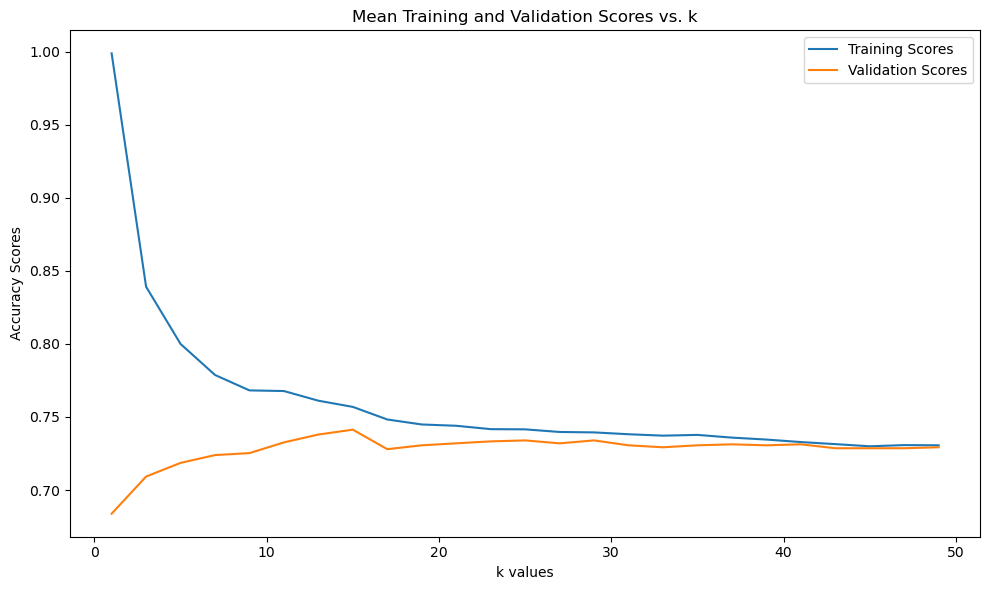

In [46]:
# Plot cross-validation results
# your code here
plt.figure(figsize= (10,6))
plt.plot(ks,training_score, label='Training Scores')
plt.plot(ks,validation_score, label='Validation Scores')
plt.xlabel("k values")
plt.ylabel("Accuracy Scores")
plt.title("Mean Training and Validation Scores vs. k")
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
print(
    "The classification accuracies for 'knn_model' where k={} "
    "are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(
        best_k, knn_train_acc, knn_cv_acc
    )
)
# create dict for storing test scores for each Q4 model
q4_cv_scores = {"knn_model": knn_cv_acc}

The classification accuracies for 'knn_model' where k=15 are:

	Train	0.7580
	CV	0.7413


<!-- END QUESTION -->

<div class='exercise-r'>

**Q4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Store the train mean cv accuracy in `logit_full_train_acc` and `logit_full_cv_acc`.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [48]:
# The code that prints your results assumes
# predictors were given to the model in this order
predictor_list = [
    "test_score", "ap", "avg_ap", "sat_subjects",
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]

In [49]:
# your code here
logit_full = LogisticRegression(
    penalty=None,
    fit_intercept=True,
    random_state=109,
    n_jobs=-1,
    max_iter=1000
).fit(X_train[predictor_list], y_train)

logit_full_train_acc = logit_full.score(X_train[predictor_list], y_train)
logit_full_cv_acc = cross_val_score(logit_full,
                                    X = X_train[predictor_list],
                                    y = y_train,
                                    cv=10,
                                    n_jobs=-1
                                    ).mean()

In [50]:
# display your results
print(
    "The intercept and coefficients for the 'logit_full' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_full.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(predictor_list, logit_full.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_full' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logit_full_train_acc, logit_full_cv_acc)
)

# store test score to dict for later use
q4_cv_scores["logit_full"] = logit_full_cv_acc

The intercept and coefficients for the 'logit_full' model are:

	intercept           -1.7415
	test_score          0.8893
	ap                  -0.1284
	avg_ap              0.0008
	sat_subjects        -0.0976
	gpa                 0.0697
	female              -0.0175
	minority            0.8088
	international       0.3067
	sports              1.0388
	harvard             0.3949
	early_app           0.6029
	alumni              0.8664

The classification accuracies for 'logit_full' are:

	Train	0.7447
	CV	0.7373


In [51]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<div class='exercise-r'>

**Q4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = np.logspace(-2, 2, 50)` and 10-fold cross-validation. Store the train and mean cross-validation accuracies in `logit_lasso_train_acc` and `logit_lasso_cv_acc`. For tuning a regularized logistic regression model, you should use `LogisticRegressionCV`. But again, to insure reproducability here, you should set `random_state=109`. 

**Hint:**
- The default solver for SKLearn's logistic regression, 'lbfgs', is not compatible with LASSO regularization, so you will need to use a different solver here. See the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) for guidance.

</div>

In [52]:
Cs = np.logspace(-2, 2, 50)
# your code here
X_train[predictor_list]

logit_lasso = LogisticRegressionCV(penalty = 'l1',
                                   fit_intercept = True,
                                   cv=10,
                                   Cs=Cs,
                                   scoring='accuracy',
                                   n_jobs = -1,
                                   random_state=109,
                                   refit=True,
                                   solver='liblinear').fit(X_train[predictor_list], y_train)

logit_lasso_cv_scores = logit_lasso.scores_[1]
# logit_lasso_cv_scores.shape -> output: (10,50) -> rows are the folds; cols are the Cs

C_best = logit_lasso.C_ # provides the best c
C_best_idx = np.where(logit_lasso.Cs_ == C_best)[0][0] # to extract the raw value
best_cv_scores = logit_lasso_cv_scores[:, C_best_idx] # Take the validation score from the best c across all folds

# store into variables
logit_lasso_train_acc = logit_lasso.score(X_train[predictor_list], y_train)
logit_lasso_cv_acc = best_cv_scores.mean()



In [53]:
# Display your results
print(
    "The intercept and coefficients for the 'logit_lasso' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_lasso.intercept_).flatten()[0]
    )
)

# Again, this code assumes predictors were given to the model
# in the order defined in `predictor_list`
for predictor, coef in zip(predictor_list, logit_lasso.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_lasso' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logit_lasso_train_acc, logit_lasso_cv_acc)
)

# store cv score to dict for later use
q4_cv_scores["logit_lasso"] = logit_lasso_cv_acc

The intercept and coefficients for the 'logit_lasso' model are:

	intercept           -1.5207
	test_score          0.8187
	ap                  -0.0967
	avg_ap              -0.0240
	sat_subjects        -0.0689
	gpa                 0.0283
	female              -0.0029
	minority            0.6527
	international       0.0000
	sports              0.5988
	harvard             0.2628
	early_app           0.4534
	alumni              0.6012

The classification accuracies for 'logit_lasso' are:

	Train	0.7420
	CV	0.7380


In [54]:
grader.check("q4.4")

q4.4 results: All test cases passed!

<div class='exercise-r'>

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Here we assume that any predictors with zero-valued Lasso coefficients "unimportant". Store your results in `predictors_important` and `predictors_not_important`.
 
</div>

In [55]:
# your code here
predictors_important = []
predictors_not_important = []

for predictor, coef in zip(predictor_list, logit_lasso.coef_.ravel()):
    print(predictor + str(coef))
    if coef != 0:
        predictors_important.append(predictor)
    else:
        predictors_not_important.append(predictor)


test_score0.8186725137304212
ap-0.09674787504826558
avg_ap-0.024016187146384375
sat_subjects-0.06887109811067195
gpa0.02828790818802233
female-0.0029095393439709733
minority0.65265594702808
international0.0
sports0.5988462870035786
harvard0.26276965311540407
early_app0.4534122656066695
alumni0.6012040049294546


In [56]:
# display results
print(
    "The following predictors were deemed important by "
    "'logit_lasso' (i.e. coef != 0):\n\n\t{}\n\n\n"
    "While, the remaining were deemed unimportant (i.e. "
    "coef == 0):\n\n\t{}"
    .format(
        predictors_important,
        predictors_not_important,
    )
)

The following predictors were deemed important by 'logit_lasso' (i.e. coef != 0):

	['test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa', 'female', 'minority', 'sports', 'harvard', 'early_app', 'alumni']


While, the remaining were deemed unimportant (i.e. coef == 0):

	['international']


In [57]:
grader.check("q4.5")

q4.5 results: All test cases passed!

<div class='exercise-r'>

**Q4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `lasso_interact`).  Again use `Cs = np.logspace(-2, 2, 50)`,  and 10-fold cross-validation with classification accuracy as the scoring metric. Record the accuracy on train and test for this model in `lasso_interact_train_acc` and `lasso_interact_test_acc`.

</div>

In [58]:
# your code here
poly = PolynomialFeatures(degree=2,
                          interaction_only=True,
                          include_bias=False)
X_train_4_6 = poly.fit_transform(X_train[predictors_important]) 
X_test_4_6 = poly.transform(X_test[predictors_important]) # has already learned the parameters

In [59]:
Cs = np.logspace(-2, 2, 50)
# your code here
...
lasso_interact = LogisticRegressionCV(penalty = 'l1',
                                   fit_intercept = True,
                                   cv=10,
                                   Cs=Cs,
                                   scoring='accuracy',
                                   n_jobs = -1,
                                   random_state=109,
                                   refit=True,
                                   solver='liblinear').fit(X_train_4_6, y_train)
...
lasso_interact_train_acc = lasso_interact.score(X_train_4_6, y_train)
lasso_interact_cv_acc = lasso_interact.score(X_test_4_6, y_test)


In [60]:
print(
    "\nThe classification accuracies for 'logit_lasso_interact' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}\n"
    .format(lasso_interact_train_acc, lasso_interact_cv_acc)
)

# store test score to dict for later use
q4_cv_scores["lasso_interact"] = lasso_interact_cv_acc


The classification accuracies for 'logit_lasso_interact' are:

	Train	0.7547
	CV	0.7253



<div class='exercise-r'>

**Q4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? Store these numbers in `num_important_coefs` and `num_unimportant_coefs`. 
    
</div>

In [61]:
# your code here
coefs = lasso_interact.coef_[0]

num_important_coefs = np.count_nonzero(coefs)
num_unimportant_coefs = np.count_nonzero(coefs==0)

In [62]:
print(
    "Of the {} predictors used in our 'logit_lasso_interact' model:"
    "\n\n\t{} predictors were deemed 'important' by our model"
    "\n\t{} predictors were deemed 'unimportant' with 0-valued "
    "coefficients".format(
        num_important_coefs + num_unimportant_coefs,
        num_important_coefs,
        num_unimportant_coefs
    )
)

Of the 66 predictors used in our 'logit_lasso_interact' model:

	44 predictors were deemed 'important' by our model
	22 predictors were deemed 'unimportant' with 0-valued coefficients


In [63]:
grader.check("q4.7")

q4.7 results: All test cases passed!

---

<a id="part5"></a>

## <div class='exercise'>Question 5: Evaluating results</div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.1** Which of the 4 models in Question 4 performs the best based on cross-validation accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model's performance on the training data back in Question 1.1? What does this comparison to the "naive" model tell us?
    
</div>

In [64]:
# your code here
print("The CV accuracies for the 4 models in Q4 are:\n")
for key, value in q4_cv_scores.items():
    print("\t{:<25}{:.4f}".format(key, value))
print(
    "\nThe  accuracy for our original baseline \"naive\" "
    "model was {:.4f}".format(naive_train_acc)
)

The CV accuracies for the 4 models in Q4 are:

	knn_model                0.7413
	logit_full               0.7373
	logit_lasso              0.7380
	lasso_interact           0.7253

The  accuracy for our original baseline "naive" model was 0.7299


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

- The best performing model is the k-Nearest Neighbors (knn_model) with the highest CV accuracy of 0.7413.
- The worst performing model is the Logistic Regression with LASSO regularization and all two-way interaction terms (lasso_interact), with the lowest CV accuracy of 0.7253.
- Three of the four models (knn_model, logit_full, and logit_lasso) outperform our original baseline "naive" model, which had an accuracy of 0.7299. Only the lasso_interact model performs slightly worse than the naive model.

This comparison tells us whether our more complex models provide additional predictive power compared to the naive approach. The higher CV accuracies of most models indicate that they are indeed capturing meaningful patterns in the data, allowing for better classification than simply assuming everyone gets rejected. However, the marginal improvements suggest that while these models offer some benefit, the gain in predictive power is modest. The poor performance of the lasso_interact model relative to the naive model suggests that including all two-way interactions may have led to overfitting, despite the use of LASSO regularization.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.2** Draw an ROC curve for each of the four models on a single plot.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?

**Hint:** Use `cross_val_predict` with `method='predict_proba` to get the probability predictions required to construct the ROC curves.
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The ROC curves are quite similar overall, but we're looking for the upside-down 'L' shape to identify better models. The `knn_model` appears to perform the worst, as its curve is closest to the diagonal line.

The ROC curves do not support the conclusion from Question 5.1 that the `knn_model` is better than the `lasso_interact` model. Ideally, the `knn_model` curve should be above the `lasso_interact` curve, indicating a higher AUC. However, we observe the opposite: the `lasso_interact` curve is above the `knn_model` curve and has a higher AUC, suggesting it performs better in distinguishing between classes.

This likely has something to do with the relationship between the 'True Positive Rate' and the 'False Positive Rate', which we'll talk more about in the next part.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

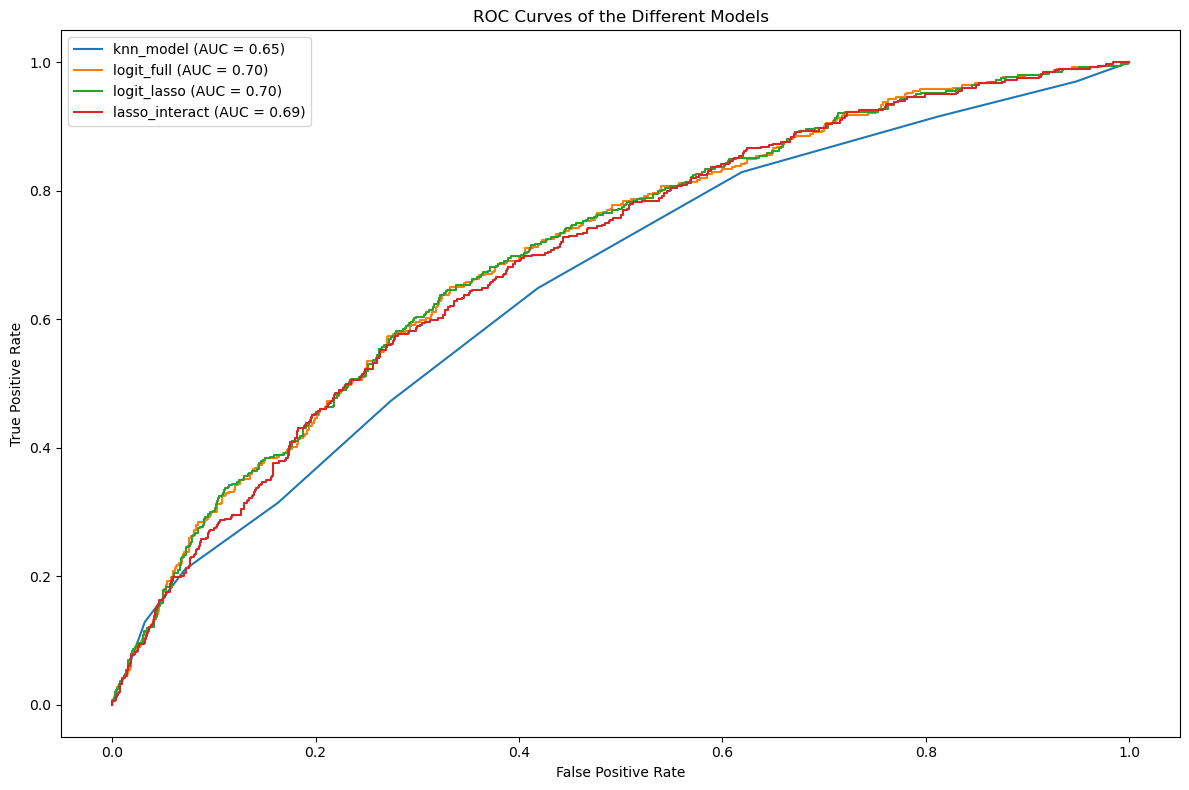

In [65]:
# your code here
models = {
    'knn_model': knn_model,
    'logit_full': logit_full,
    'logit_lasso': logit_lasso,
    'lasso_interact': lasso_interact
}

aucs = {}

plt.figure(figsize=(12, 8))
for name, model in models.items():
        
        if name != 'lasso_interact':
            y_proba = cross_val_predict(model, 
                                        X_train[predictor_list], 
                                        y_train, 
                                        cv=10, 
                                        method='predict_proba')
        else:
            y_proba = cross_val_predict(model, 
                                        X_train_4_6, 
                                        y_train, 
                                        cv=10, 
                                        method='predict_proba')

        fpr, tpr, _ = roc_curve(y_train, y_proba[:, 1])
        roc_auc = roc_auc_score(y_train, y_proba[:, 1]) # instead of using auc
        aucs[name] = roc_auc
        
        # plot
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
plt.legend()
plt.title("ROC Curves of the Different Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()

In [66]:
# your code here
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.3** Calculate the AUC for all 4 models and store these in `auc_list`. **The order of AUCs in the list should match the order of the model as they appear in `q4_cv_scores`.**
    
Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

No, the rankings of these 4 models based on their AUCs do not match the classification accuracy. While `knn_model` had the highest classification accuracy, it has the lowest AUC. This discrepancy suggests that `knn_model` may increase the true positive rate more sharply at the expense of a higher false positive rate compared to other models. 

AUC provides a measure of a model's ability to distinguish between classes across all thresholds, while accuracy is a single threshold metric. The higher AUC values for `logit_full` and `logit_lasso` indicate that these models maintain a better balance between true positive and false positive rates across various thresholds, leading to more consistent performance in distinguishing between classes. 

In contrast, `knn_model` might achieve high accuracy by correctly classifying many instances at a specific threshold but does not perform as well when considering the overall trade-off between sensitivity and specificity. This highlights the importance of evaluating models using multiple metrics to gain a comprehensive understanding of their performance.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [67]:
# your code here
# calculate each model's AUC using its ROC fpr and tpr
auc_list = list(aucs.values())

In [68]:
print(
    "The CV accuracies & CV AUC scores for the 4 models in Q4 are:"
    "\n\n\t\t\t\tAccuracy\tAUC"
)
for (key, value), auc_value in zip(q4_cv_scores.items(), auc_list):
    print("\t{:<24}{:.4f}\t\t{:.4f}".format(key, value, auc_value))

The CV accuracies & CV AUC scores for the 4 models in Q4 are:

				Accuracy	AUC
	knn_model               0.7413		0.6534
	logit_full              0.7373		0.7013
	logit_lasso             0.7380		0.7024
	lasso_interact          0.7253		0.6946


In [69]:
grader.check("q5.3")

q5.3 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.4** Select your preferred model based on the cross-validation accuracy and AUC. For this 'final model', display the accuracy and AUC scores on the **test data**. Compare these to the accuracy and AUC score of the naive model from 1.1 when predicting on the test data. Would you offer your final model as a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale? Why or why not? What might be some consequences of the deployment of the model into the real world?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Based on the cross-validation accuracy and AUC, my preferred model is `logit_lasso`, which balances both metrics well. On the test data, this model achieves an accuracy of 0.7440 and an AUC of 0.6216, outperforming the naive model's accuracy of 0.7307 and AUC of 0.0000.

I would consider offering this model as a publicly available tool for college applicants, as it provides insights into the probability of acceptance, not just rejection. This could be valuable for applicants seeking to understand their chances more holistically and might present a business opportunity.

However, deploying such a model comes with potential consequences. It could inadvertently discourage applicants who rely too heavily on its predictions without considering other qualitative factors that admissions committees evaluate. Additionally, there's a risk of reinforcing biases present in the training data, potentially leading to unfair assessments for certain groups.

Overall, while the model offers benefits, careful consideration and transparency about its limitations are crucial before making it publicly available. However, if I was profit-driven, I might be inclined to release it regardless.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [70]:
final_model_y_hat = logit_lasso.predict(X_test[predictor_list])
final_model_y_proba = logit_lasso.predict_proba(X_test[predictor_list])

final_test_accuracy = logit_lasso.score(X_test[predictor_list], y_test)
final_test_auc = roc_auc_score(y_test, final_model_y_proba[:,1])

naive_test_accuracy = np.count_nonzero(y_test==0) / len(y_test)
naive_test_auc = 0 # tpr=fpr=0

print(f'Final Accuracy: {final_test_accuracy:.4f}' )
print(f'Final AUC: {final_test_auc:.4f}' )

print(f'Naive Accuracy: {naive_test_accuracy:.4f}' )
print(f'Naice AUC: {naive_test_auc:.4f}' )

Final Accuracy: 0.7440
Final AUC: 0.6216
Naive Accuracy: 0.7307
Naice AUC: 0.0000


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<a id="part6"></a>

## <div class='exercise'>Question 6: BONUS!</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q6 (optional)** Incorporate what you've learned from the PCA and/or Missingness sections of the course to create a new, improved classification model. You could focus on improving predictive performance, inference, interpretability, or all of the above! 

Be sure to also describe your approach and analyze your results.

While this section is optional, we highly encourge you to experiment (and not just for the sake of the potential bonus points 😉).

**Note:** Though you should report the test performance of this new, "bonus" model, selecting the bonus model over the 'final model' from Q5.4 would have to be justified based on cross-validation performance, *not* test performance! 
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In response to the question, I applied PCA to try improve the classification model by trying to improve the predictive performance. I hoped that the dimensionality reduction would have resulted in a more parsimonious model.

### **Approach:**
1. **Dimensionality Reduction with PCA:**
   - I applied PCA to the training data (`X_train[predictors]`) to reduce the number of features while retaining most of the variance in the dataset. The cumulative explained variance plot (shown in the image) indicates that around 8 principal components explain approximately 90% of the variance in the data.
   - Based on this analysis, I selected 8 principal components for further modeling.

2. **Logistic Regression Model:**
   - After transforming both the training and test datasets using PCA, I trained a logistic regression model with L1 regularization (Lasso) on the reduced feature set (8 principal components).
   - The logistic regression model was chosen for its simplicity and interpretability, and L1 regularization was used to enforce sparsity, which can help with feature selection and reduce overfitting.

3. **Model Evaluation:**
   - I evaluated the model’s performance by comparing its accuracy on both the training and test sets.
   - Additionally, I compared this PCA-based model’s performance with a previously trained logistic regression model (`logit_lasso`), as well as a naive baseline model.

### **Results:**
- The PCA-based logistic regression model achieved:
  - **Train Accuracy:** 0.7386
  - **Test Accuracy:** 0.7253
- For comparison:
  - **logit_lasso Test Accuracy:** 0.7440
  - **Naive Test Accuracy:** 0.7307

### **Analysis:**
- The PCA-based model performed slightly worse than the `logit_lasso` model on the test set (0.7253 vs. 0.7440). It was also outperformed by the naive baseline (0.7253 vs. 0.7307).
- The PCA's test accuracy being below the other two suggests that while PCA effectively reduced dimensionality and retained most of the variance, a lot of predictive power may have been lost by discarding components beyond the first 8.
- Despite this, PCA offers significant benefits in terms of computational efficiency by reducing the feature space from its original size to just 8 components.

### **Conclusion:**
The PCA-based model was likely not a good model to incorporate in this situation, evidenced by its lackluster test accuracy. This trade-off between accuracy and dimension reduction may be valuable depending on project goals. If computational efficiency is prioritized, this PCA-based approach could be a viable alternative, with a simpler model structure and reduced feature set.

I would stick with the `logit_lasso` model.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Train Accuracy of 8 PCA components: 0.7386
Test Accuracy of 8 PCA components: 0.7253
logit_lasso Test Accuracy: 0.7440
Naive Test Accuracy: 0.7307


/Users/main/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


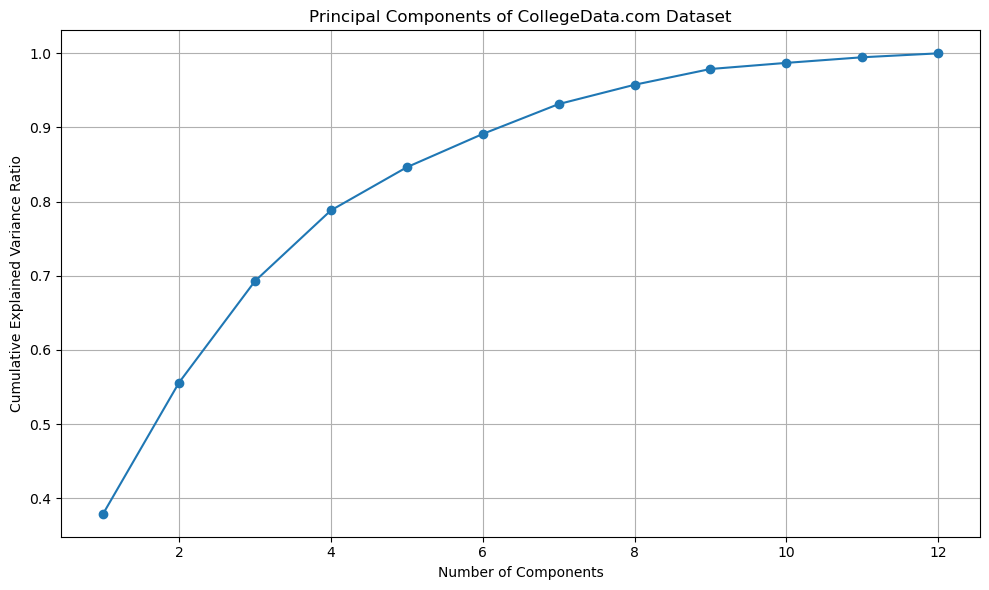

In [71]:
from sklearn.decomposition import PCA

# Fit the PCA model
pca = PCA().fit(X_train[predictors])

# Get the number of components
n_components = len(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Principal Components of CollegeData.com Dataset')
plt.grid(True)
plt.tight_layout()

# Eyeball Test
eyeballed_n = 8

X_pca_train = pca.transform(X_train[predictors])
X_pca_test = pca.transform(X_test[predictors])

pcr = LogisticRegression(penalty = 'l1',
                        fit_intercept=True,
                        random_state=109,
                        n_jobs=-1,
                        solver='liblinear',
                        max_iter=1000,
                        ).fit(X_pca_train[:,:eyeballed_n], y_train)

train_accuracy = pcr.score(X_pca_train[:, :eyeballed_n], y_train)
test_accuracy = pcr.score(X_pca_test[:, :eyeballed_n], y_test)

print(f'Train Accuracy of 8 PCA components: {train_accuracy:.4f}' )
print(f'Test Accuracy of 8 PCA components: {test_accuracy:.4f}' )
print(f'logit_lasso Test Accuracy: {final_test_accuracy:.4f}' )
print(f'Naive Test Accuracy: {naive_test_accuracy:.4f}' )



Tired 😴 My eyes hurt

<!-- END QUESTION -->

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

Classification Boundary was Hard

In [72]:
hours_spent_on_hw = 16

In [73]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [74]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

It took 0.64 minutes for this notebook to run


🌈 **This concludes HW5. Thank you!**

[Return to contents](#contents)